In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [3]:
#rdf = pd.read_csv("../../../Downloads/oakland_rentals_in_2014.csv")
cdf = pd.read_csv("data/OPD_150308.csv")

In [4]:
cdf.Date = pd.to_datetime(cdf.Date)
#cdf.drop(['Time','Idx'], inplace=True, axis=1)
#cdf = cdf[cdf.Date < pd.datetime(2015, 1, 1)][cdf.Date > pd.datetime(2013,12,31)]
#cdf.drop(['Time','Idx','OPD_RD', 'OIdx', 'Beat', 'Src', 'UCR', 'Statute'], inplace=True, axis=1)

In [ ]:
rdf_map = rdf[['price','createdate','latitude','longitude']]

In [14]:
cdf_map = cdf[['CrimeCat','Date','Lat','Lng']]

In [ ]:
rdf_map.head()

In [ ]:
cdf_map.head()

In [ ]:
rdf_map.to_csv("rdf.csv")

In [ ]:
cdf_map.to_csv("cdf.csv")

In [15]:
dfday = cdf[cdf['CrimeCat'] == 'ASSAULT'].groupby(['Date','CrimeCat']).Lat.count()

In [33]:
#Assault over all years

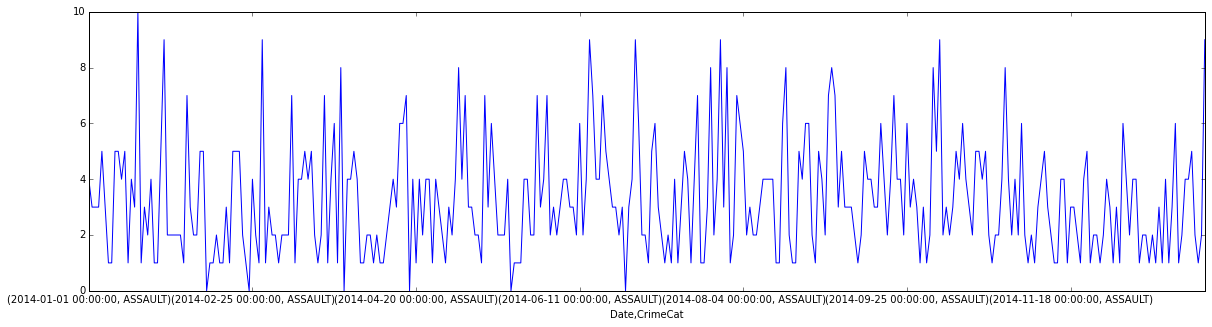

In [32]:
dfday.plot(figsize=(20,5))

###Lovely Data EDA/Model 

In [103]:
# Read in data. Preliminarily drop id, emailid, phoneid, squarefeet, abstract,
# locationtitle, latitude/longitude, and neighborhood/baths null values.
# id is unique for each entry
# emailid has 515 unique entries (no null entries)
# phoneid has 141 unique entries (790 entries total)
# squarefeet has 1002 entries, missing for ~1/3 of data
# abstract: consider later for feature creation or nlp
# neighborhood has 14 null entries
# locationtitle: consider later for feature creations
# createdate: consider later for time series analysis
# latitude/longitude: consider later for analysis

rdf = pd.read_csv("data/oakland_rentals_in_2014.csv")
rdf.createdate = pd.to_datetime(rdf.createdate)
rdf.drop(['id','emailid','phoneid','squarefeet', 'abstract', 'locationtitle', 'createdate', 'baths', 'latitude', 'longitude'], axis=1, inplace=True)
d = {'t':True, 'f':False, True:True, False:False}
columns = rdf.columns[4:35]
for col in columns:
    rdf[col] = rdf[col].map(d)
rdf = rdf.dropna()

In [91]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1422 entries, 0 to 1435
Data columns (total 25 columns):
price              1422 non-null int64
beds               1422 non-null int64
feedid             1422 non-null int64
neighborhood       1422 non-null object
buzzerintercom     1422 non-null bool
pool               1422 non-null bool
fireplace          1422 non-null bool
gym                1422 non-null bool
elevator           1422 non-null bool
doorman            1422 non-null bool
dishwasher         1422 non-null bool
deckorpatio        1422 non-null bool
privateyard        1422 non-null bool
walkincloset       1422 non-null bool
dog                1422 non-null bool
cat                1422 non-null bool
washerdryer        1422 non-null bool
hardwoodfloors     1422 non-null bool
newappliances      1422 non-null bool
vaultedceilings    1422 non-null bool
centralair         1422 non-null bool
storagespace       1422 non-null bool
yardshared         1422 non-null bool
parkingoutdoor

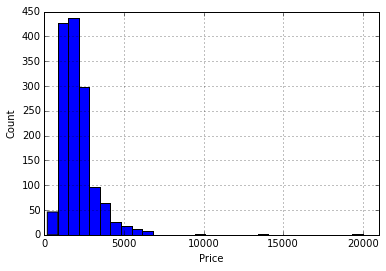

In [117]:
# Identify price outliers
plt.xlabel('Price')
plt.ylabel('Count')
plt.xlim(0,21000)
rdf.price.hist(bins=30)

{'boxes': [<matplotlib.lines.Line2D at 0x10c25c150>],
 'caps': [<matplotlib.lines.Line2D at 0x10c269110>,
 'fliers': [<matplotlib.lines.Line2D at 0x10c273410>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x10c269d90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x10c25c3d0>,
  <matplotlib.lines.Line2D at 0x10c25ca90>]}

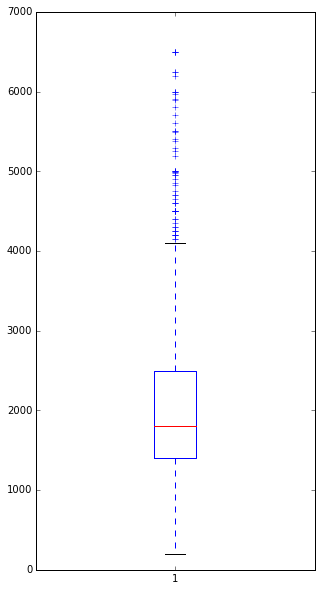

In [119]:
plt.figure(figsize=(5,10))
plt.ylim(0,7000)
plt.boxplot(rdf.price.values)

In [299]:
rdf.sort('price', ascending=False).head()
# Yup, the four price outliers (price > 9999) look off. Three are repeats of same listing,
# one (id 1119) has abstract "This is a test entry"

,id,price,beds,baths,createdate,abstract,feedid,emailid,phoneid,squarefeet,...,cat,washerdryer,hardwoodfloors,newappliances,vaultedceilings,centralair,storagespace,yardshared,parkingoutdoor,parkinggarage
444,14621735,20000,5,3.0,02/12/2014 09:06:53.341825,"Sublet.com Listing ID 2389496 Over 6,000 sq....",9,23866759,6920,NaN,...,f,f,f,f,f,f,f,f,f,f
1119,18334694,14000,1,1.0,09/05/2014 12:28:28.203675,This is just a test property,16,2603643,NaN,NaN,...,t,f,t,t,f,f,f,f,f,f
401,15014835,9999,3,3.0,03/08/2014 09:02:26.095025,Sublet.com Listing ID 2400351 Located only 1...,9,25314171,6920,NaN,...,f,t,f,f,f,f,f,f,f,f
69,14327450,9999,3,3.0,01/29/2014 09:06:43.048621,Sublet.com Listing ID 2345887 Located only 1...,9,19087126,6920,NaN,...,f,t,f,f,f,f,f,f,f,f
413,14287252,6500,4,4.5,01/27/2014 14:29:19.403918,4BR/4.5BA 5-Level Hillside Home\r\n Beautiful ...,16,3936,4673,NaN,...,f,t,t,t,t,t,t,f,t,t


In [305]:
# Drop price outliers (four rows)
rdf = rdf[rdf.price < 9999]

In [104]:
rdf_model = pd.get_dummies(rdf, prefix='nbh_', columns=['neighborhood'], sparse=True)

In [105]:
rdf_model.head()

,price,beds,feedid,buzzerintercom,pool,fireplace,gym,elevator,doorman,dishwasher,...,nbh__Toler Heights,nbh__Trestle Glen,nbh__Tuxedo,nbh__Upper Peralta Creek,nbh__Upper Rockridge,nbh__Uptown,nbh__Webster,nbh__Wentworth Holland,nbh__Woodland,nbh__Woodminster
0,795,1,1,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1395,1,26,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4200,4,1,False,True,True,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325,0,26,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1495,2,26,False,True,False,False,False,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [307]:
y = rdf_model.pop('price')

In [308]:
rdf_train, rdf_test, y_train, y_test = train_test_split(rdf_model, y)

In [309]:
rfc = RandomForestRegressor(n_estimators=1000, n_jobs=-1)

In [310]:
rfc.fit(rdf_train, y_train)

RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0)

In [311]:
rfc.score(rdf_test, y_test)

0.65917030376131258

In [312]:
zip(rdf_model.columns, rfc.feature_importances_)

[('beds', 0.26606785888627266),
 ('feedid', 0.049460649850362005),
 ('buzzerintercom', 0.0017041336634887093),
 ('pool', 0.0070246512257791912),
 ('fireplace', 0.1055793799404645),
 ('gym', 0.012811865405591505),
 ('elevator', 0.031523940856190542),
 ('doorman', 0.0029084107974689365),
 ('dishwasher', 0.022333707497237173),
 ('deckorpatio', 0.045478944898108262),
 ('privateyard', 0.0095006044643171049),
 ('walkincloset', 0.012945281984821576),
 ('dog', 0.036783703418539072),
 ('cat', 0.01322888911933982),
 ('washerdryer', 0.014094543127191878),
 ('hardwoodfloors', 0.013232133240410006),
 ('newappliances', 0.0077916974063686082),
 ('vaultedceilings', 0.003306383931152416),
 ('centralair', 0.0031955636825020685),
 ('storagespace', 0.014099275232692924),
 ('yardshared', 0.002122056204551213),
 ('parkingoutdoor', 0.010480539062762582),
 ('parkinggarage', 0.013561553872199492),
 ('nbh__Acorn', 0.0),
 ('nbh__Acorn Industrial', 0.0094610711802483819),
 ('nbh__Adams Point', 0.00387836524584449

###Remove feedid (or dummy, but for now, remove)

In [286]:
rdf_train_lr = np.hstack((rdf_train[:,:2],rdf_train[:,3:]))
rdf_test_lr = np.hstack((rdf_test[:,:2], rdf_test[:,3:]))

In [287]:
lr = LinearRegression(normalize=True, copy_X=True)

In [294]:
lr.fit(rdf_train_lr, y_train)

LinearRegression(copy_X=True, fit_intercept=True, normalize=True)

In [295]:
lr.score(rdf_test_lr, y_test)

-1.7033337018347707e+23

In [269]:
zip(rdf_model.columns, lr.coef_)

[('beds', 411.2190537319637),
 ('baths', 128.53266301212125),
 ('feedid', -1.1258727660873975),
 ('buzzerintercom', -91.997290559085485),
 ('pool', -41.224059879152769),
 ('fireplace', 208.91103239960299),
 ('gym', 346.11810482287717),
 ('elevator', 2.2161107137355454),
 ('doorman', -109.55663851459299),
 ('dishwasher', 160.68108169671515),
 ('deckorpatio', 99.079228292042899),
 ('privateyard', 114.1096352649657),
 ('walkincloset', 72.121563918987803),
 ('dog', -2.6678089406228671),
 ('cat', -26.225921479010687),
 ('washerdryer', 76.416458073188778),
 ('hardwoodfloors', 144.31987189185978),
 ('newappliances', 135.12369253206978),
 ('vaultedceilings', -178.0881379493679),
 ('centralair', -247.36604869333598),
 ('storagespace', 87.417490856656755),
 ('yardshared', 136.29502764543685),
 ('parkingoutdoor', -63.544477782058912),
 ('parkinggarage', -48.740628928514155),
 ('nbh__Acorn', 5791544490669506.0),
 ('nbh__Acorn Industrial', 5791544490671366.0),
 ('nbh__Adams Point', 5791544490670645

###Crime Data - Preliminary Categories By Year

In [5]:
cdf['year'] = pd.DatetimeIndex(cdf.Date).year

In [6]:
#make sub plots showing count of crime over years
#where year < 2015

#cdf.groupby(['CrimeCat','year']).Idx.count()
#cdf.CrimeCat.value_counts()
#cdf[cdf.CrimeCat == "COURT_MISDEMEANOR"].Desc.value_counts()

In [87]:
d = {}
for col in cdf.CrimeCat.unique()[1:]:
    if col.find("ASSAULT") == 0:
        d[col] = "VIOLENT"
    elif col.find("ROBBERY") == 0:
        d[col] = "VIOLENT"
    elif col.find("KIDNAPPING") == 0:
        d[col] = "VIOLENT"
    elif col.find("ARSON") == 0:
        d[col] = "VIOLENT"
    elif col.find("WEAPONS") == 0:
        d[col] = "VIOLENT"
    elif col.find("HOMICIDE") == 0:
        d[col] = "VIOLENT"
    elif col.find("SEX_RAPE") == 0:
        d[col] = "VIOLENT"
    elif col.find("SEX_OTHER") == 0:
        d[col] = "VIOLENT"
    elif col.find("LARCENY_THEFT_VEHICLE") == 0:
        d[col] = "VEHICLE_THEFT"
    elif col.find("OTHER_RECOVERED") == 0:
        d[col] = "VEHICLE_THEFT"
    elif col.find("LARCENY_BURGLARY_AUTO") == 0:
        d[col] = "VEHICLE_BREAK_IN"
    elif col.find("LARCENY") == 0:
        d[col] = "NONVIOLENT"
    elif col.find("SEX_PROSTITUTION") == 0:
        d[col] = "QUALITY"
    elif col.find("VANDALISM") == 0:
        d[col] = "QUALITY"
    elif col.find("QUALITY") == 0:
        d[col] = "QUALITY"
    elif col.find("TRAFFIC_DUI") == 0:
        d[col] = "QUALITY"
    elif col.find("DOM-VIOL") == 0:
        d[col] = "DOM-VIOL"
    elif col.find("MENTAL-ILLNESS") == 0:
        d[col] = "OTHER"
    elif col.find("COURT") == 0:
        d[col] = "WARRANT"
    else: d[col] = col

In [88]:
cdf['CrimeCat'] = cdf.CrimeCat.map(d)
#pd.get_dummies(cdf, columns=['CrimeCat'])

In [386]:
cdf_map = cdf[cdf['CrimeCat'].isin(assault)][cdf.year < 2015]

In [388]:
cdf_map[['Date','Lat','Lng']].to_csv("assault_by_year.csv")

In [119]:
cdf.drop(['OPD_RD', 'OIdx', 'CType', 'Desc', 'Beat', 'Addr', 'Src', 'UCR', 'Statute'], axis=1, inplace=True)

In [129]:
cdf_dummy = pd.get_dummies(cdf, prefix='CTYPE_', columns=['CrimeCat'])

In [162]:
cdf['Year_Month'] = cdf.Date.map(lambda x: 1000*x.year + x.month)

AttributeError: 'str' object has no attribute 'year'

In [11]:
cdf.groupby(['CrimeCat','year']).Idx.count().to_csv("crime_cat_years.csv")

### Here's where I figure out problems with data. Reverting to using CType and need to cut by CID.

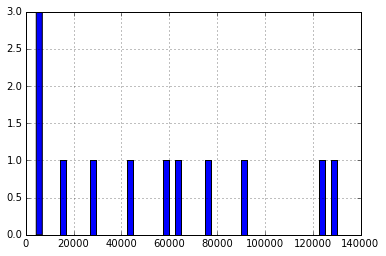

In [101]:
cdf.CrimeCat.value_counts().hist(bins=50)

In [102]:
duplicates = cdf[cdf.duplicated('OPD_RD')].OPD_RD.unique()
output = []
for row in cdf[cdf.OPD_RD.isin(duplicates)].itertuples():
    output.append((row[2], row[15]))
output = sorted(output, key=lambda tup: tup[0], reverse=True)

In [104]:
len(sorted(set(output), key=lambda tup: tup[0]))

127258

In [103]:
len(output)

263328

In [105]:
output

[('94-022117', 'VIOLENT'),
 ('94-022117', nan),
 ('92-010944', 'VIOLENT'),
 ('92-010944', 'VIOLENT'),
 ('92-010944', 'VIOLENT'),
 ('70-002824', 'NONVIOLENT'),
 ('70-002824', 'NONVIOLENT'),
 ('15-004007', 'VIOLENT'),
 ('15-004007', 'VIOLENT'),
 ('15-000218', 'VEHICLE_THEFT'),
 ('15-000218', 'VEHICLE_THEFT'),
 ('14-914822', nan),
 ('14-914822', 'VEHICLE_BREAK_IN'),
 ('14-066002', nan),
 ('14-066002', 'NONVIOLENT'),
 ('14-065621', 'NONVIOLENT'),
 ('14-065621', 'NONVIOLENT'),
 ('14-064824', nan),
 ('14-064824', 'NONVIOLENT'),
 ('14-064330', 'VIOLENT'),
 ('14-064330', nan),
 ('14-063420', 'VIOLENT'),
 ('14-063420', nan),
 ('14-062498', 'NONVIOLENT'),
 ('14-062498', 'NONVIOLENT'),
 ('14-062377', 'VIOLENT'),
 ('14-062377', nan),
 ('14-061895', 'VIOLENT'),
 ('14-061895', 'VIOLENT'),
 ('14-060402', 'VIOLENT'),
 ('14-060402', nan),
 ('14-056652', 'VEHICLE_BREAK_IN'),
 ('14-056652', 'VEHICLE_BREAK_IN'),
 ('14-053895', 'VIOLENT'),
 ('14-053895', nan),
 ('14-053849', nan),
 ('14-053849', 'NONVIOLEN